<a href="https://colab.research.google.com/github/DominionAkinrotimi/PyDataQuality/blob/main/PyDataQuality_Master_Class_The_Complete_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyDataQuality Master Class: The Complete Walkthrough**

**By:** Dominion Akinrotimi  
**Environment:** Google Colab / Jupyter Notebook

This is your master guide to `pydataquality`. It covers every single functionality of the library, from basic audits to advanced AI remediation and CLI usage.

---


## 1. 🛠️ Installation & Setup
First, install the library.

In [1]:
# Install from TestPyPI
!pip install -i https://test.pypi.org/simple/ pydataquality==0.1.4

# Install dependencies
!pip install pandas numpy matplotlib seaborn jinja2

Looking in indexes: https://test.pypi.org/simple/


## **2. Data Generation (The "Dirty" Datasets)**
We will use two datasets to test different features:
1.  **Synthetic Retail Data**: Generated randomly with specific issues (outliers, nulls).
2.  **Titanic Dataset**: A classic standard dataset (via seaborn) to test real-world patterns.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pydataquality as pdq
from datetime import datetime, timedelta

In [3]:
# --- DATASET A: Synthetic Retail (The "Dirty" One) ---
np.random.seed(42)
rows = 1000
dirty_df = pd.DataFrame({
    'id': range(rows),
    'date': [datetime(2023, 1, 1) + timedelta(days=int(x)) for x in np.random.randint(0, 365, rows)],
    'amount': np.random.uniform(10, 1000, rows),
    'age': np.random.randint(18, 90, rows),
    'category': np.random.choice(['A', 'B', 'C', None], rows), # Has Missing
    'region': ['North'] * rows # Low Cardinality
})

# Inject Issues
dirty_df.loc[0:5, 'amount'] = [50000, -100, 100000, 0, 50000, 20] # Outliers
dirty_df.loc[10:15, 'age'] = [150, 200, -1, 999, 500, 0] # Outliers & Sentinel (999)

# --- DATASET B: Titanic (Real World) ---
titanic_df = sns.load_dataset('titanic')

print("✅ Datasets Ready!")

✅ Datasets Ready!


## **3. The 10-Second Audit (`quick_quality_check`)**
Use this for a sub-second JSON summary. Great for automated pipelines.

In [4]:
# Check the Dirty Dataset
summary = pdq.quick_quality_check(dirty_df, name="Dirty Retail")

# Print clean JSON
import json
print(json.dumps(summary, indent=2, default=str))

{
  "dataset": {
    "name": "Dirty Retail",
    "rows": 1000,
    "columns": 6,
    "total_cells": 6000,
    "memory_usage_mb": 0.12357711791992188,
    "analysis_timestamp": "2025-12-18T01:37:40.881608"
  },
  "columns": 6,
  "issues_by_severity": {
    "critical": 0,
    "warning": 3,
    "info": 4
  },
  "issues_by_type": {
    "outliers": 2,
    "skewed_distribution": 2,
    "missing_values": 1,
    "low_cardinality": 2
  },
  "column_types": {
    "numeric": 3,
    "datetime": 1,
    "categorical": 2
  },
  "missing_data_overview": {
    "columns_with_missing": 1,
    "total_missing_cells": "252",
    "total_missing_percentage": 4.2,
    "columns": [
      {
        "column": "category",
        "missing_count": "252",
        "missing_percentage": 25.2
      }
    ]
  }
}


## **4. 📊 The Interactive Dashboard (`show_report`)**
This is the main visual tool. It supports 3 themes.

### Theme 1: Creative (Default)
Modern, dark-mode accessible.

In [5]:
analyzer = pdq.analyze_dataframe(dirty_df, name="Dirty Retail")
pdq.show_report(analyzer, theme='creative')

Column,Issue,Severity,Message,Affected,Details
amount,Outliers,WARNING,"Found 3 outliers outside range [-528.83, 1535.16]",3 (0.3%),"50000.0, 100000.0, 50000.0"
amount,Skewed Distribution,INFO,Distribution is skewed (skewness = 21.34),-,
age,Outliers,WARNING,"Found 4 outliers outside range [-16.50, 123.50]",4 (0.4%),"150, 200, 999, 500"
age,Skewed Distribution,INFO,Distribution is skewed (skewness = 15.34),-,
category,Missing Values,WARNING,Moderate percentage of missing values (25.2%),252 (25.2%),
category,Low Cardinality,INFO,Low cardinality: 3 unique values for 1000 rows,3 (0.3%),
region,Low Cardinality,INFO,Low cardinality: 1 unique values for 1000 rows,1 (0.1%),



### Theme 2: Professional
Clean, white background. Best for screenshots/management.

In [6]:
pdq.show_report(analyzer, theme='professional')

Severity,Column,Issue,Impact,Details
WARNING,amount,"Found 3 outliers outside range [-528.83, 1535.16]",3 rows (0.3%),"50000.0, 100000.0, 50000.0"
WARNING,age,"Found 4 outliers outside range [-16.50, 123.50]",4 rows (0.4%),"150, 200, 999, 500"
WARNING,category,Moderate percentage of missing values (25.2%),252 rows (25.2%),


### Theme 3: Simple
Minimalist. Best for quick checks.

In [7]:
pdq.show_report(analyzer, theme='simple')

## **5. 📑 generating PDF/HTML Reports (`generate_report`)**
You can save reports to file and download them (works in Colab!).



In [8]:
# Generate HTML file
pdq.generate_report(analyzer, output_path="quality_report.html", theme='professional')

# In Colab, perform download:
try:
    from google.colab import files
    files.download('quality_report.html')
except ImportError:
    print("Report saved locally as 'quality_report.html'")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Report is downloaded as a .html file directly to your device**

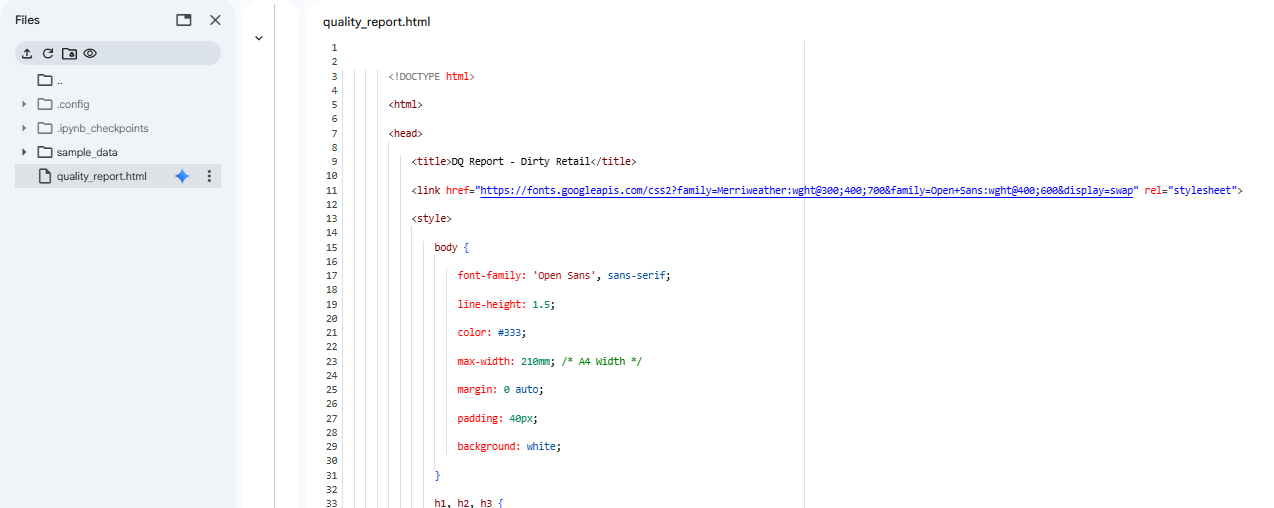




**You can then print/save the downloaded html report as PDF once it is open in your browser**


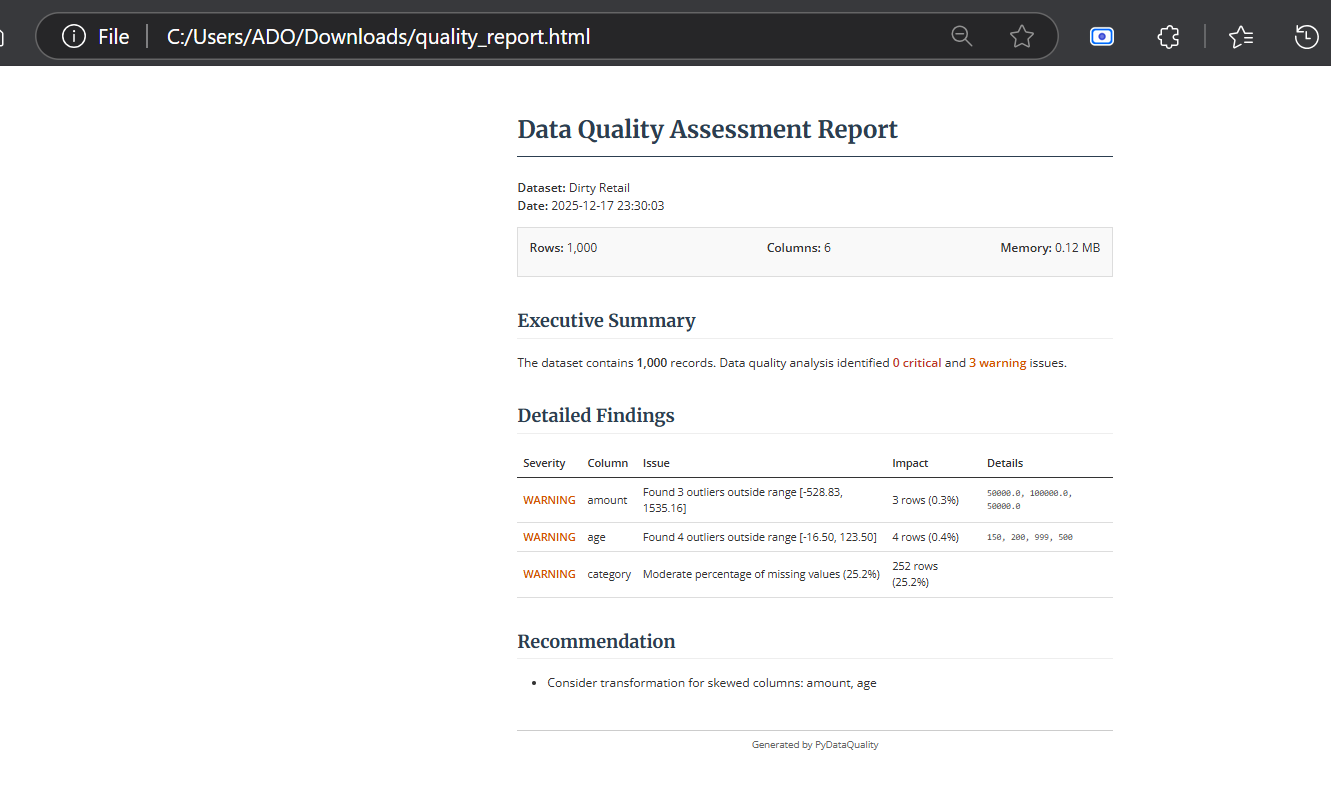



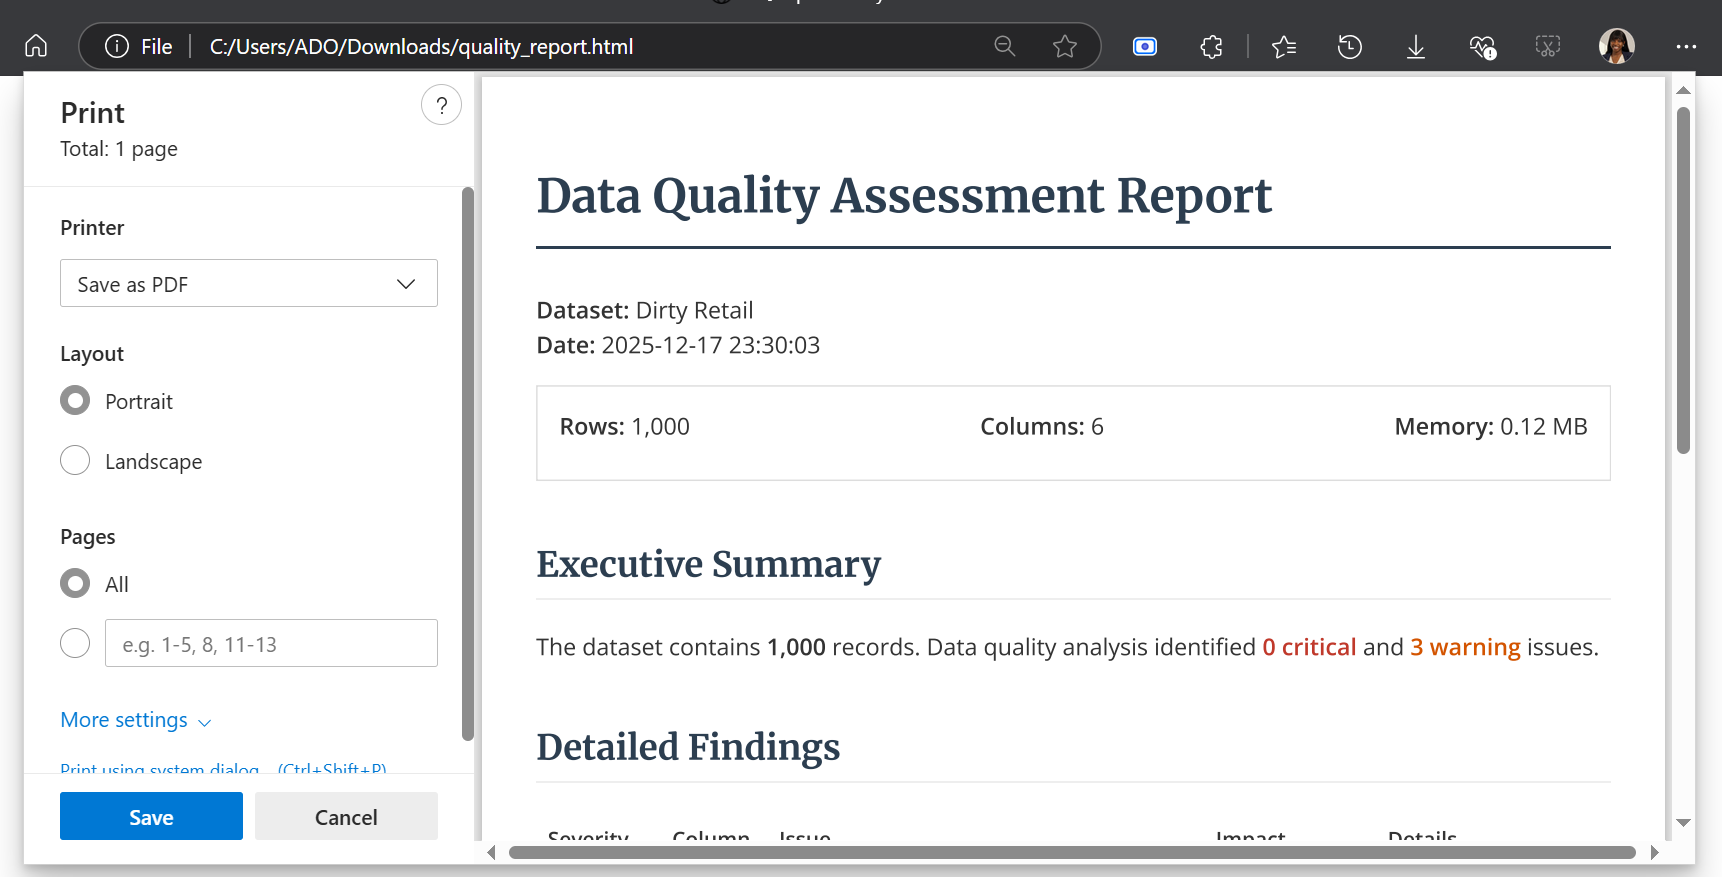

## **6. 🖥️ The Command Line Interface (CLI)**
You don't even need Python code. You can run checks directly from the terminal.

In [9]:
# Save our dataframe to CSV first
dirty_df.to_csv('data.csv', index=False)

# Run CLI check
!python -m pydataquality data.csv --output cli_report.html

Successfully loaded data.csv with 1000 rows and 6 columns
Loaded dataset: 1000 rows, 6 columns
Report saved to: cli_report.html/Dataset_quality_report.html

ANALYSIS SUMMARY
Critical issues: 0
Warning issues: 4
Total missing: 252 (4.2%)


## **7. 🕵️ Detective Work: Investigating False Positives**
Before we assume everything is a real error, let's verify. Our report flagged `999` and `-1` as outliers in Age.
Let's inspect the actual rows to confirm:

In [10]:
# Use the initial analyzer to get the flagged rows
initial_outliers = analyzer.get_problematic_rows('age', 'outliers')
print("Initially Flagged Ages:")
print(initial_outliers['age'].unique())
# You will see: [150, 200, -1, 999, 500, 0]
# 999 is likely a "Sentinel Value" (Legacy Code for Unknown)

Initially Flagged Ages:
[150 200 999 500]


In [11]:
# Use the initial analyzer to get the flagged rows
initial_outliers = analyzer.get_problematic_rows('amount', 'outliers')
print("Initially Flagged Ages:")
print(initial_outliers['amount'].unique())

Initially Flagged Ages:
[ 50000. 100000.]


## **extract every single row that has ANY issue**

In [12]:
# 1. Start with a mask of all False (assuming no rows are bad initially)
all_bad_mask = pd.Series(False, index=dirty_df.index)
# 2. Iterate through every column that has issues
for issue in analyzer.issues:
    # Get the bad rows for this specific column/issue
    # We use 'all' to capture missing values, outliers, etc.
    bad_rows_df = analyzer.get_problematic_rows(issue.column, issue_type='all')

    # Update our master mask (OR operation)
    all_bad_mask = all_bad_mask | dirty_df.index.isin(bad_rows_df.index)
# 3. Extract the full dataset of "bad" rows
full_bad_dataset = dirty_df[all_bad_mask]
print(f"Found {len(full_bad_dataset)} rows with at least one issue.")
print(full_bad_dataset.head())

Found 259 rows with at least one issue.
    id       date         amount  age category region
0    0 2023-04-13   50000.000000   49        A  North
2    2 2023-09-28  100000.000000   48        A  North
4    4 2023-03-13   50000.000000   35        A  North
10  10 2023-11-27     762.625581  150        B  North
11  11 2023-03-29     599.682353  200        C  North


## **8. 🧠 Advanced Logic: Handling False Positives**
In our data, `age=999` is a sentinel value for "Unknown", not an outlier error.
We use `exclude_values` to teach the library this rule.

In [13]:
config = {
    'exclude_values': {
        'age': [999],   # Monitor: Ignore 999
        'amount': [-100]    # Monitor: Ignore specific refund code
    },
    'missing_critical': 0.4 # Relax missing threshold
}

# Re-analyze with intelligence
smart_analyzer = pdq.analyze_dataframe(dirty_df, config=config)

# Verify 999 is ignored
bad_rows = smart_analyzer.get_problematic_rows('age', 'outliers')
print("Flagged Ages:", bad_rows['age'].unique())
# Should NOT see 999

Flagged Ages: [150 200 500]


## **9. ⛏️ Data Extraction (`get_problematic_rows`)**
Extract the bad data so you can send it to Data Engineering.

In [14]:
# Get all 'amount' outliers
bad_amounts = smart_analyzer.get_problematic_rows('amount', issue_type='outliers')
bad_amounts.to_csv('bad_transactions.csv')
print(f"Extracted {len(bad_amounts)} rows.")

Extracted 3 rows.


## **10. 🤖 AI Remediation (`generate_ai_prompt`)**
The "Magic Button". Generates a context-aware prompt (with EDA stats) to fix the data.

In [15]:
# Generating prompt for the Titanic dataset
titanic_analyzer = pdq.analyze_dataframe(titanic_df, name="Titanic")
prompt = pdq.generate_ai_prompt(titanic_analyzer)
print("--- AI PROMPT ---")
print(prompt)

--- AI PROMPT ---
I have a dataset 'Titanic' with 891 rows. It has the following quality issues: age (missing_values: 19.9% missing), age (outliers: outside [-6.69, 64.81]), sibsp (outliers: outside [-1.50, 2.50]), parch (outliers: outside [0.00, 0.00]), fare (outliers: outside [-26.72, 65.63]), deck (missing_values: 77.2% missing). 

Here is the statistical context (EDA) for the affected columns:
- parch (int64): Mean=0.38, Median=0.00, Min=0.00, Max=6.00
- fare (float64): Mean=32.20, Median=14.45, Min=0.00, Max=512.33
- sibsp (int64): Mean=0.52, Median=0.00, Min=0.00, Max=8.00
- deck (category): Unique Values=7, Top Value='C'
- age (float64): Mean=29.70, Median=28.00, Min=0.42, Max=80.00

Please write a Python script using pandas to clean this dataset. Consider different strategies (e.g., capping vs removal for outliers, imputation vs dropping for missing) based on the logic and EDA context provided above. Provide a brief explanation of your chosen strategy.


## **11. 🔬 Advanced Usage: Internal Modules**
You can access the lower-level modules for more granular control.


---
### 11.1 Custom Visualizations (`DataQualityVisualizer`)
Generate specific plots without running the full report.

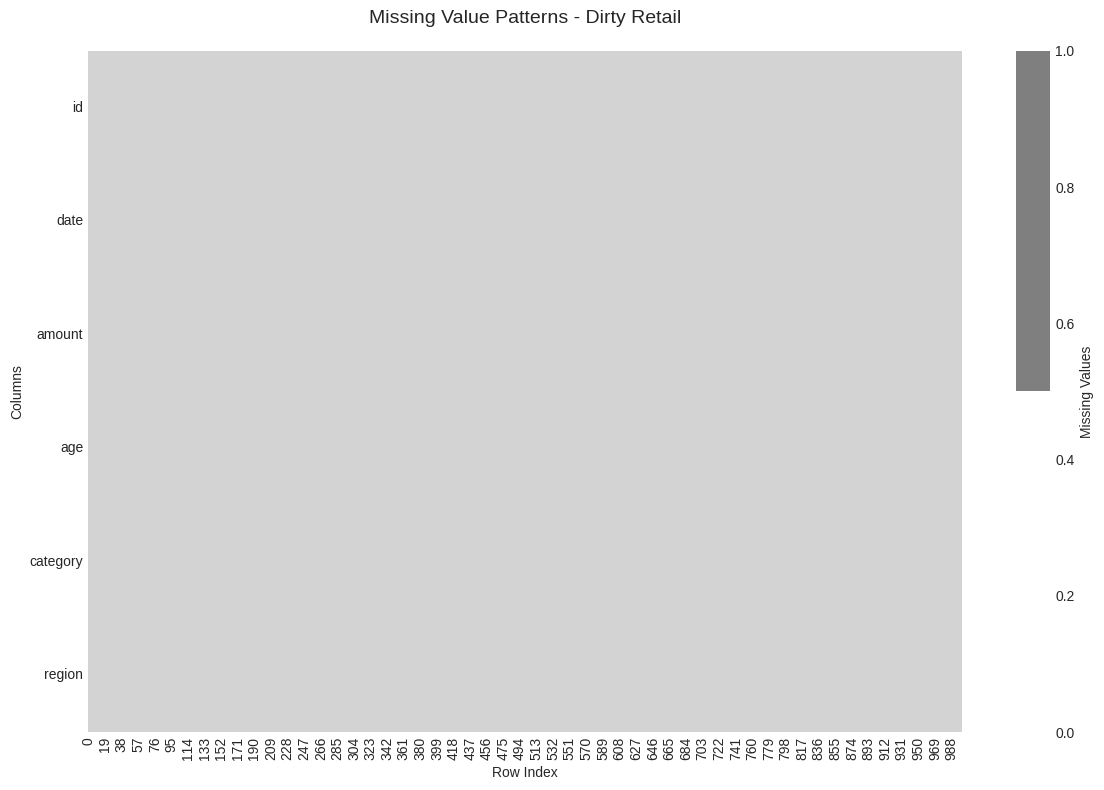

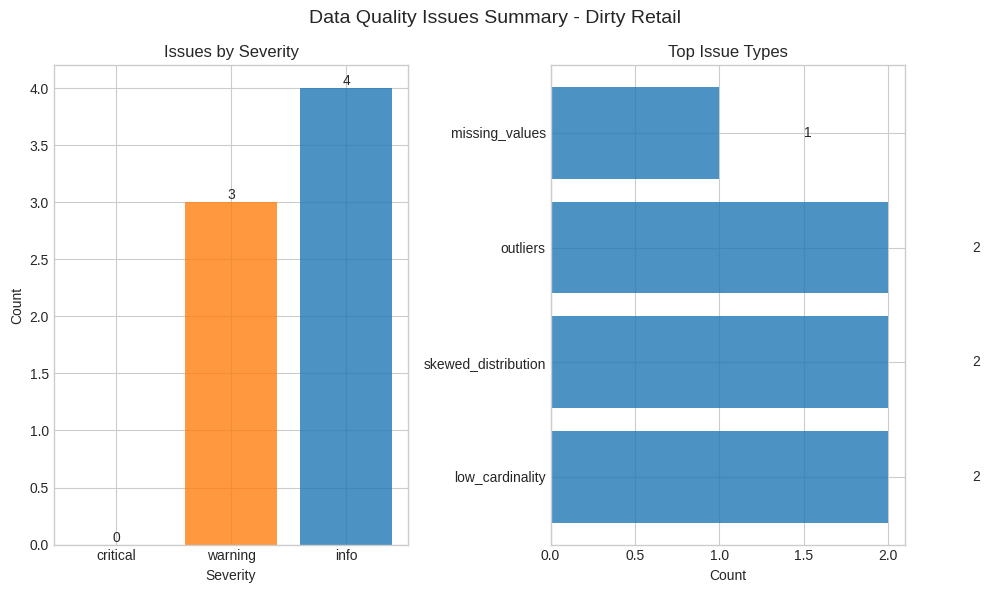

In [16]:
# Create a visualizer instance
visualizer = pdq.DataQualityVisualizer(analyzer)
# 1. Missing Values Matrix (Heatmap)
fig = visualizer.create_missing_values_matrix()
fig.show()
# 2. Issues Summary Chart
fig2 = visualizer.create_issues_summary_chart()
fig2.show()

### 11.2 Utility Functions
Useful standalone tools for your data pipelines.

In [17]:
# 1. Detect Column Types
types = pdq.detect_column_types(dirty_df)
print("Detected Types:", types)

# 2. Estimate Memory Usage
print("\n Memory Size:", pdq.format_memory_size(dirty_df.memory_usage(deep=True).sum()))

# 3. Smart Sampling (for massive datasets)
# Retains distribution while cutting size
sampled_df = pdq.sample_dataframe(dirty_df, n_samples=100)
print(f"\n Sampled Shape: {sampled_df.shape}")

Detected Types: {'numeric': ['id', 'amount', 'age'], 'categorical': ['region'], 'datetime': ['date'], 'boolean': [], 'text': [], 'other': ['category']}

 Memory Size: 126.54 KB

 Sampled Shape: (100, 6)


# **🌟 Bonus 1: Detecting "Data Drift" (The Comparator)**
You can actually **compare two datasets** (e.g., "Last Month" vs "This Month") to see if your data is drifting (e.g., Mean/Std Dev changing).

In [18]:
# Create two distinct datasets
df_jan = pdq.analyze_dataframe(dirty_df, name="January Data")
df_feb = pdq.analyze_dataframe(dirty_df.iloc[100:], name="February Data") # Slight shift
# Compare them!
from pydataquality.comparator import compare_reports
drift_report = compare_reports(df_jan, df_feb)
print("📉 Data Drift Report:")
print(drift_report[['column', 'ref_mean', 'curr_mean', 'pct_change']])

📉 Data Drift Report:
   column    ref_mean   curr_mean  pct_change
0      id  499.500000  549.500000   10.010010
1  amount  706.704446  506.513884  -28.327339
2     age   54.700000   53.301111   -2.557384


# **🌟 Bonus 2: The "Big Data" Loader**
If you have a 5GB CSV file, `pd.read_csv()` will crash your RAM. The library has a hidden `sample_large_dataset` tool that reads in chunks automatically.

In [19]:
# Generate a dummy large CSV file
import numpy as np
import pandas as pd
print("Generating 'massive_file.csv'... (this might take a moment)")
df_big = pd.DataFrame(np.random.randn(500000, 5), columns=list('ABCDE')) # 500k rows
df_big.to_csv('massive_file.csv', index=False)
print("✅ Created 'massive_file.csv'")

Generating 'massive_file.csv'... (this might take a moment)
✅ Created 'massive_file.csv'


In [22]:
from pydataquality.utils import sample_large_dataset

In [23]:
# Smartly samples a 5GB file without loading it all
# (Reads in chunks of 100k rows, returns a representative 10k sample)
big_sample_df = sample_large_dataset("massive_file.csv", n_samples=10000)
# Now run the check on the sample!
pdq.quick_quality_check(big_sample_df)

{'dataset': {'name': 'Dataset',
  'rows': 10000,
  'columns': 5,
  'total_cells': 50000,
  'memory_usage_mb': np.float64(0.457763671875),
  'analysis_timestamp': '2025-12-18T01:41:14.786539'},
 'columns': 5,
 'issues_by_severity': {'critical': 0, 'warning': 5, 'info': 0},
 'issues_by_type': {'outliers': 5},
 'column_types': {'numeric': 5},
 'missing_data_overview': {'columns_with_missing': 0,
  'total_missing_cells': np.int64(0),
  'total_missing_percentage': np.float64(0.0),
  'columns': []}}

# **🌟 Bonus 3: Finding Duplicate/Correlated Columns**
There is a utility to find columns that are essentially the same (high correlation > 0.95), which confuses ML models.

In [24]:
from pydataquality.utils import find_duplicate_columns
# Creates a list of column groups that are highly correlated
duplicates = find_duplicate_columns(dirty_df, threshold=0.95)
if duplicates:
    print(f"⚠️ Warning: The following columns are redundant: {duplicates}")
else:
    print("✅ No redundant columns found.")

✅ No redundant columns found.


### **The "Visual Debugger" (Custom Plots)**
The `show_report()` function hides the individual plots. You can pull them out for your own custom dashboards (e.g., just the Correlation Matrix).

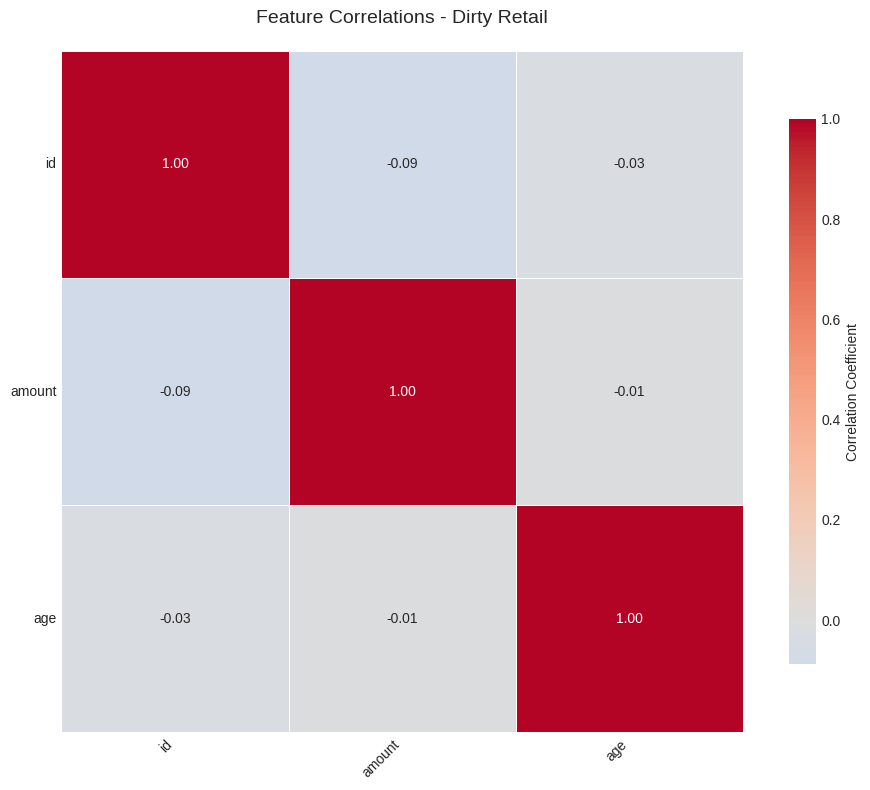

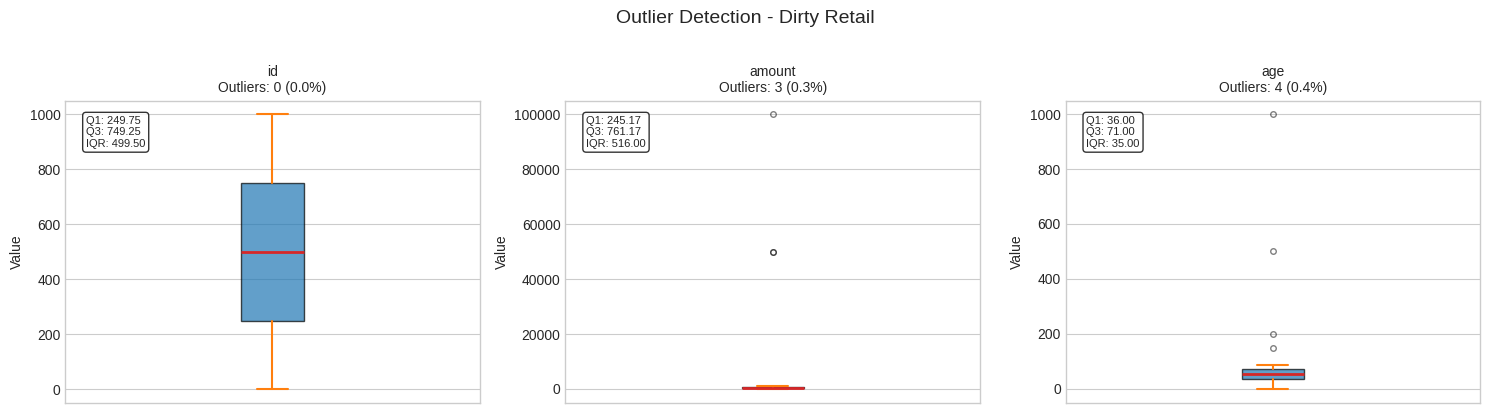

In [25]:
from pydataquality.visualizer import DataQualityVisualizer
import matplotlib.pyplot as plt
# 1. Create the Visualizer Tool
viz = DataQualityVisualizer(analyzer)
# 2. Generate SPECIFIC plots (High Resolution)
fig_corr = viz.create_correlation_heatmap(figsize=(10, 8))
plt.show() # Shows only the correlation matrix
fig_outliers = viz.create_outlier_detection_plot()
plt.show() # Shows only the boxplots

### **The "Data Health Scorecard" (0-100 Score)**
The library doesn't give a single score, but we can calculate one ourselves based on the analyzer.issues. This is great for a "Go/No-Go" decision in a pipeline.

In [26]:
# Calculate a custom "Health Score"
total_issues = len(analyzer.issues)
total_columns = len(analyzer.column_stats)
critical_issues = sum(1 for i in analyzer.issues if i.severity == 'critical')
# Simple Algorithm: Start at 100, subtract 10 for critical, 2 for warning
health_score = 100 - (critical_issues * 10) - ((total_issues - critical_issues) * 2)
health_score = max(0, health_score) # limit to 0
print(f"❤️ Data Health Score: {health_score}/100")
if health_score < 80:
    print("❌ REJECT DATASET")
else:
    print("✅ DATASET APPROVED")

❤️ Data Health Score: 86/100
✅ DATASET APPROVED


---
**End of Master Class.**